In [1]:
from helper import *
from copy import deepcopy

# Device detection and setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

set_seed = 42

Using device: cpu


In [2]:
# Iris Network
class IrisNet(nn.Module):
    def __init__(self):
        super(IrisNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 3)

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [3]:
# Iris Dataset
iris = sklearn_datasets.load_iris()
X_iris = torch.FloatTensor(iris.data)
y_iris = torch.LongTensor(iris.target)

# Shuffle the dataset before splitting (deterministic with seed)
np.random.seed(42)
indices = np.random.permutation(len(X_iris))
X_iris_shuffled = X_iris[indices]
y_iris_shuffled = y_iris[indices]

# Split into train/test
split = int(0.80 * len(X_iris_shuffled))
X_iris_train, X_iris_test = X_iris_shuffled[:split], X_iris_shuffled[split:]
y_iris_train, y_iris_test = y_iris_shuffled[:split], y_iris_shuffled[split:]

iris_train_loader = DataLoader(TensorDataset(X_iris_train, y_iris_train), batch_size=32, shuffle=False)
iris_test_loader = DataLoader(TensorDataset(X_iris_test, y_iris_test), batch_size=32, shuffle=False)

In [14]:
# First Model
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.001)
losses, model, val_losses, val_accuracies = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=100, seed=42, verbose=False, return_val=True, test_loader=iris_test_loader)
print(f"{losses[-5:]}")

All seeds set to: 42
Model weights initialized with seed: 42
[0.08444703184068203, 0.08399674668908119, 0.08357049711048603, 0.0831409702077508, 0.08272366411983967]


In [15]:
print_training_history(losses, val_losses, val_accuracies)

Training Losses (last 10 epochs):
Epoch  91: Train Loss = 0.086856, Val Loss = 0.048995, Val Acc = 1.0000
Epoch  92: Train Loss = 0.086350, Val Loss = 0.048507, Val Acc = 1.0000
Epoch  93: Train Loss = 0.085856, Val Loss = 0.048058, Val Acc = 1.0000
Epoch  94: Train Loss = 0.085366, Val Loss = 0.047621, Val Acc = 1.0000
Epoch  95: Train Loss = 0.084917, Val Loss = 0.047127, Val Acc = 1.0000
Epoch  96: Train Loss = 0.084447, Val Loss = 0.046729, Val Acc = 1.0000
Epoch  97: Train Loss = 0.083997, Val Loss = 0.046341, Val Acc = 1.0000
Epoch  98: Train Loss = 0.083570, Val Loss = 0.045921, Val Acc = 1.0000
Epoch  99: Train Loss = 0.083141, Val Loss = 0.045551, Val Acc = 1.0000
Epoch 100: Train Loss = 0.082724, Val Loss = 0.045193, Val Acc = 1.0000


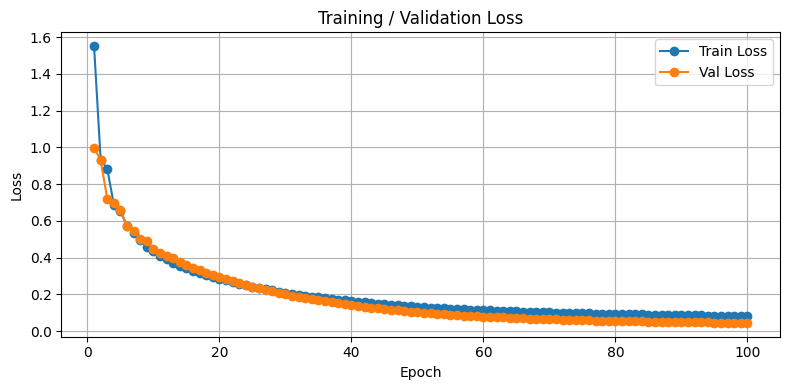

In [16]:
plot_training_history(losses, val_losses, val_accuracies)

In [17]:
base_epochs = 25
extra_epochs = 1
index = 0
k = 2

# First Model
iris_model = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer = optim.Adam(iris_model.parameters(), lr=0.001)
iris_losses_base, trained_iris_base = train_model(iris_model, iris_train_loader, iris_criterion, iris_optimizer, num_epochs=base_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_model2 = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer_v2 = optim.Adam(iris_model2.parameters(), lr=0.001)
iris_losses_base, trained_iris2 = train_model(iris_model2, iris_train_loader, iris_criterion, iris_optimizer_v2, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_inputs, iris_activations, iris_outputs = get_activations(trained_iris_base, iris_train_loader, dataset_type='iris')
single_iris_inputs, single_iris_activations, single_iris_outputs = get_activations(trained_iris_base, iris_test_loader, dataset_type='iris', indices=index)
indices_iris, distances_iris = find_knn(iris_activations, single_iris_activations, k=k, metric='l2')
filtered_iris_loader, filtered_size = create_filtered_dataloader(iris_train_loader, exclude_indices=indices_iris, batch_size=32, shuffle=False)

iris_model3 = IrisNet()
iris_criterion = nn.CrossEntropyLoss()
iris_optimizer_filter = optim.Adam(iris_model3.parameters(), lr=0.001)
iris_losses_base, trained_iris_filter = train_model(iris_model3, iris_train_loader, iris_criterion, iris_optimizer_filter, num_epochs=base_epochs+extra_epochs, seed=42, verbose=False)
print(f"{iris_losses_base[-5:]}")

iris_losses_base, trained_iris_filter = train_model(iris_model3, filtered_iris_loader, iris_criterion, iris_optimizer_filter, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)
print(f"{iris_losses_base[-1:]}")

All seeds set to: 42
Model weights initialized with seed: 42
[0.2765344828367233, 0.2668614313006401, 0.2580544129014015, 0.24989870935678482, 0.2422165907919407]
All seeds set to: 42
Model weights initialized with seed: 42
[0.2668614313006401, 0.2580544129014015, 0.24989870935678482, 0.2422165907919407, 0.2350495047867298]
All seeds set to: 42
Model weights initialized with seed: 42
[0.2668614313006401, 0.2580544129014015, 0.24989870935678482, 0.2422165907919407, 0.2350495047867298]
[0.22459128871560097]


In [18]:
predictions_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris_base, iris_test_loader, dataset_type='iris', indices=index)  # Single index
predictions_iris_v2, probabilities_iris_v2, predicted_classes_iris_v2, sample_targets_iris_v2 = predict_and_show(trained_iris2, iris_test_loader, dataset_type='iris', indices=index)  # Single index
predictions_iris__filter, probabilities_iris__filter, predicted_classes_iris__filter, sample_targets_iris_filter = predict_and_show(trained_iris_filter, iris_test_loader, dataset_type='iris', indices=index)  # Single index

print(f"{nn.CrossEntropyLoss()(predictions_iris, sample_targets_iris):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_iris_v2, sample_targets_iris_v2):.8f}")
print(f"{nn.CrossEntropyLoss()(predictions_iris__filter, sample_targets_iris_filter):.8f}")
print(f"Difference: {nn.CrossEntropyLoss()(predictions_iris__filter, sample_targets_iris_filter).item() - nn.CrossEntropyLoss()(predictions_iris_v2, sample_targets_iris_v2).item():.8f}")

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.6831      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.6906      
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
0      versicolor   versicolor   0.6902      
0.38108218
0.37025693
0.37084118
Difference: 0.00058424


In [19]:
# Function to calculate CrossEntropy loss for different k and indices (Iris version)
def calculate_cross_entropy_for_k_and_indices(base_model, train_loader, test_loader, list_of_k, list_of_indices, base_epochs=base_epochs, extra_epochs=extra_epochs):
    """
    For each k and index:
      - find k nearest neighbors for the test sample using activations from the base model
      - create a filtered dataloader excluding those k neighbours
      - train a fresh IrisNet on the full training set for `base_epochs`
      - continue training that fresh model for `extra_epochs` on the filtered set
      - evaluate cross-entropy on the test sample and store the loss

    Returns a dict with keys 'closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy', each mapping k -> list of losses (one per index).
    """
    cross_results = {
        'closest_cross_entropy': {},
        'last_cross_entropy': {},
        'random_cross_entropy': {}
    }

    # Ensure we have the base activations available (from previous cell)
    try:
        activations_ref = iris_activations
    except NameError:
        # fall back to iris_activations if present
        activations_ref = globals().get('iris_activations', None)
        if activations_ref is None:
            raise RuntimeError("iris_activations_base not found. Run the activation capture cell first.")

    for k in list_of_k:
        cross_results['closest_cross_entropy'][k] = []
        cross_results['last_cross_entropy'][k] = []
        cross_results['random_cross_entropy'][k] = []

        for index in list_of_indices:
            # Get activations for the single test sample
            single_inputs, single_activations, _ = get_activations(base_model, test_loader, dataset_type='iris', indices=index)

            # Find k-nearest neighbors across the training activations (get full ranking, then take top-k)
            indices_knn, _ = find_knn(activations_ref, single_activations, k=len(activations_ref), metric='cosine')

            closest_indices = indices_knn[:k]
            last_indices = indices_knn[-k:]
            random_indices = np.random.choice(indices_knn, k, replace=False)

            for subset_name, subset_indices in zip(['closest_cross_entropy', 'last_cross_entropy', 'random_cross_entropy'], [closest_indices, last_indices, random_indices]):
                # Create filtered dataloader excluding the chosen neighbors
                filtered_loader, _ = create_filtered_dataloader(train_loader, exclude_indices=subset_indices, batch_size=32, shuffle=False)

                # Create and train a fresh model to the base point
                fresh_model = IrisNet()
                optimizer_tmp = optim.Adam(fresh_model.parameters(), lr=0.001)
                criterion = nn.CrossEntropyLoss()

                train_model(fresh_model, train_loader, criterion, optimizer_tmp, num_epochs=base_epochs, seed=42, verbose=False, continue_training=False)

                # Continue training for extra_epochs on the filtered dataset
                if extra_epochs > 0:
                    train_model(fresh_model, filtered_loader, criterion, optimizer_tmp, num_epochs=extra_epochs, seed=42, verbose=False, continue_training=True)

                # Predict and calculate CrossEntropy loss for the single test sample
                predictions, _, _, targets = predict_and_show(fresh_model, test_loader, dataset_type='iris', indices=index)
                cross_loss = nn.CrossEntropyLoss()(predictions, targets).item()
                cross_results[subset_name][k].append(cross_loss)

    return cross_results

In [20]:
list_of_k = list(range(1, 76, 5))
#list_of_k = [1, 5, 10, 50, 100, 250]

list_of_indices = list(range(1, 30, 1))
random_indices = random.sample(list_of_indices, k=15)

In [21]:
cross_results = calculate_cross_entropy_for_k_and_indices(trained_iris_base, iris_train_loader, iris_test_loader, list_of_k, random_indices)

All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
21     versicolor   versicolor   0.8285      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
21     versicolor   versicolor   0.8302      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
21     versicolor   versicolor   0.8333      
All seeds set to: 42
Model weights initialized with seed: 42
Iris Predictions:
------------------------------------------

In [22]:
cross_results['closest_cross_entropy']

{1: [0.18812432885169983,
  0.01637602224946022,
  0.2030831277370453,
  0.041506078094244,
  0.2669259309768677,
  0.021263957023620605,
  0.2332453578710556,
  0.29941341280937195,
  0.25480297207832336,
  0.30743396282196045,
  0.5314011573791504,
  0.05421348661184311,
  0.22596882283687592,
  0.007559502962976694,
  0.22599288821220398],
 6: [0.20214013755321503,
  0.01656305603682995,
  0.20781314373016357,
  0.04290147125720978,
  0.2797498404979706,
  0.021520433947443962,
  0.24718372523784637,
  0.32942304015159607,
  0.27243250608444214,
  0.33602550625801086,
  0.5299574136734009,
  0.05573221668601036,
  0.24353399872779846,
  0.00762398075312376,
  0.2521102726459503],
 11: [0.21898922324180603,
  0.016832930967211723,
  0.21196961402893066,
  0.04400018975138664,
  0.2947947382926941,
  0.02184670977294445,
  0.2656691074371338,
  0.3632149398326874,
  0.29314717650413513,
  0.37313026189804077,
  0.6021870374679565,
  0.057017162442207336,
  0.2776147127151489,
  0.0077

Iris Predictions:
------------------------------------------------------------
Index  True         Pred         Confidence  
------------------------------------------------------------
28     versicolor   versicolor   0.7775      
Base error for index 28: 0.25166658


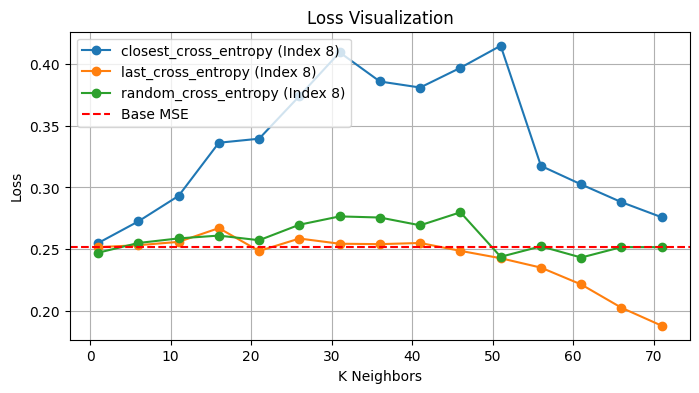

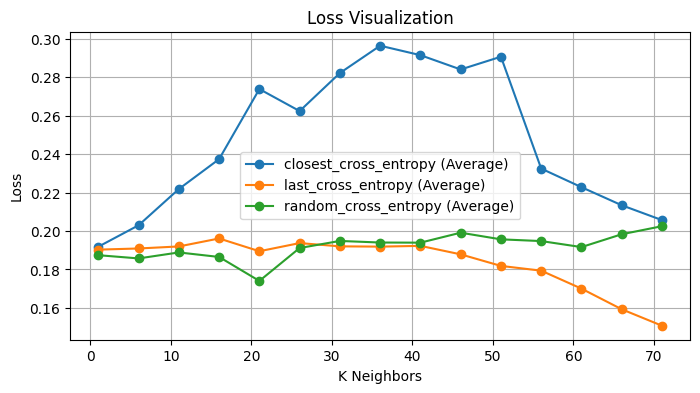

In [30]:
index_base = random_indices[8]
index_pos = random_indices.index(index_base)
predictions_base_iris, probabilities_iris, predicted_classes_iris, sample_targets_iris = predict_and_show(trained_iris2, iris_test_loader, dataset_type='iris', indices=index_base)
base_error = nn.CrossEntropyLoss()(predictions_base_iris, sample_targets_iris)
print(f"Base error for index {index_base}: {base_error:.8f}")

# Limit plotted K values by max_knn (e.g., 10) instead of positional max_points
visualize_results(cross_results, random_indices, selected_index=index_pos, base_mse=base_error, normalize=False, title="Loss Visualization", ylabel="Loss", max_knn=100)
visualize_results(cross_results, random_indices, average=True, normalize=False)

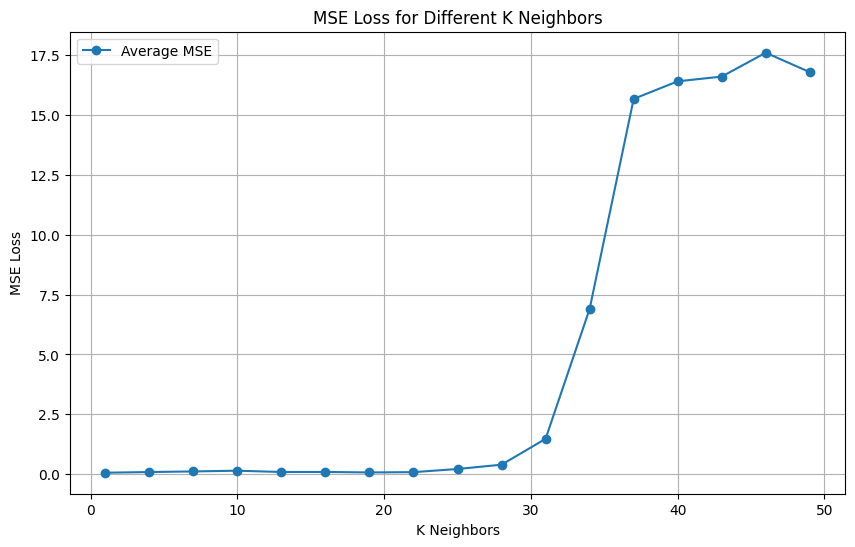

In [96]:
visualize_mse_results(cross_results, list_of_indices, average=True)  # Visualize averaged results

In [24]:
def visualize_results(mse_results, list_of_indices, selected_index=None, average=False, base_mse=None, normalize=False, title="Loss Visualization", ylabel="Loss", max_points=None, max_knn=None):
    import matplotlib.pyplot as plt
    import numpy as np

    plt.figure(figsize=(8, 4))

    def keys_for(results):
        # Ensure ks are sorted numeric K values
        ks = sorted(list(results.keys()))
        # If a maximum K value is supplied, only keep ks <= max_knn
        if max_knn is not None:
            ks = [k for k in ks if k <= max_knn]
        # If a maximum count is supplied, trim to that many points
        if max_points is not None:
            ks = ks[:max_points]
        return ks

    if average:
        averages = {}
        for key, results in mse_results.items():
            ks = keys_for(results)
            if len(ks) == 0:
                print(f"No k values selected for {key} (check max_knn/max_points).")
                averages[key] = []
                continue
            averages[key] = [np.mean(results[k]) for k in ks]

        if normalize and any(len(v) > 0 for v in averages.values()):
            max_value = max([max(values) for values in averages.values() if len(values) > 0])
            if max_value != 0:
                averages = {key: [val / max_value for val in values] for key, values in averages.items()}

        for key, values in averages.items():
            ks = keys_for(mse_results[key])
            if len(ks) == 0:
                continue
            plt.plot(ks, values, label=f"{key} (Average)", marker="o")

    elif selected_index is not None:
        for key, results in mse_results.items():
            ks = keys_for(results)
            if len(ks) == 0:
                continue
            try:
                plt.plot(ks, [results[k][selected_index] for k in ks], label=f"{key} (Index {selected_index})", marker="o")
            except IndexError:
                print(f"Selected index {selected_index} out of range for some k in {key}.")

    else:
        for key, results in mse_results.items():
            ks = keys_for(results)
            if len(ks) == 0:
                continue
            values_matrix = [results[k] for k in ks]
            for idx, values in enumerate(zip(*values_matrix)):
                plt.plot(ks, list(values), label=f"{key} (Index {idx})", marker="o")

    if base_mse is not None:
        plt.axhline(y=base_mse, color="r", linestyle="--", label="Base MSE")

    plt.xlabel("K Neighbors")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
